# Tokenization in Large Language Models: A Complete Guide

## Problem Statement
Understanding how text is converted into numerical representations that LLMs can process is crucial for:
- Optimizing prompt engineering
- Managing token limits and costs
- Understanding model behavior and limitations
- Building efficient text processing pipelines

This notebook demonstrates different tokenization methods, their trade-offs, and practical implications.

## 1. What is Tokenization?

Tokenization is the process of breaking down text into smaller units (tokens) that can be processed by machine learning models. In LLMs, tokens are the basic units of input and output.

**Key Concepts:**
- **Token**: A unit of text (word, subword, or character)
- **Vocabulary**: Set of all possible tokens the model knows
- **Token ID**: Numerical representation of each token
- **Out-of-Vocabulary (OOV)**: Tokens not in the model's vocabulary

In [6]:
# Install required packages - RESTART KERNEL after running this cell
import subprocess
import sys

packages = ['tiktoken', 'transformers', 'matplotlib', 'numpy']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

print("\n*** IMPORTANT: Please restart the kernel (Kernel -> Restart) and then run the next cell ***")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tiktoken]
  Using cached transformers-4.56.1-py3-none-any.whl.metadata (42 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached safetensors-0.6.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached hf_xet-1.1.9-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.7 kB)
Using cached transformers-4.56.1-py3-none-any.whl (11.6 MB)
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
Using cached hf_xet-1.1.9-cp37-abi3-macosx_11_0_arm64.whl (2.6 MB)
Using cached tokenizers-0.22.0-cp39-abi3-macosx_11_0_arm64.whl (2.9 MB)
Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)
Using cached safetensors-0.6.

In [1]:
# Import all required libraries (run this AFTER restarting kernel)
import re
import tiktoken
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
import re
import tiktoken
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

## 2. Simple Tokenization Methods

In [3]:
# Sample text for demonstration
sample_text = "Hello world! This is a demonstration of tokenization in LLMs. It's fascinating how models understand text."

print(f"Original text: {sample_text}")
print(f"Text length: {len(sample_text)} characters")

Original text: Hello world! This is a demonstration of tokenization in LLMs. It's fascinating how models understand text.
Text length: 106 characters


### 2.1 Word-Level Tokenization

In [4]:
def word_tokenize(text):
    # Simple word tokenization using regex
    tokens = re.findall(r'\b\w+\b|[^\w\s]', text.lower())
    return tokens

word_tokens = word_tokenize(sample_text)
print(f"Word tokens: {word_tokens}")
print(f"Number of tokens: {len(word_tokens)}")

Word tokens: ['hello', 'world', '!', 'this', 'is', 'a', 'demonstration', 'of', 'tokenization', 'in', 'llms', '.', 'it', "'", 's', 'fascinating', 'how', 'models', 'understand', 'text', '.']
Number of tokens: 21


### 2.2 Character-Level Tokenization

In [5]:
def char_tokenize(text):
    return list(text)

char_tokens = char_tokenize(sample_text)
print(f"Character tokens: {char_tokens[:20]}...")  # Show first 20
print(f"Number of tokens: {len(char_tokens)}")

Character tokens: ['H', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 'T', 'h', 'i', 's', ' ', 'i', 's']...
Number of tokens: 106


## 3. Modern Tokenization: Byte Pair Encoding (BPE)

BPE is a subword tokenization method that balances vocabulary size with meaningful representations.

### 3.1 Simple BPE Implementation

In [6]:
class SimpleBPE:
    def __init__(self, vocab_size=1000):
        self.vocab_size = vocab_size
        self.vocab = {}
        self.merges = {}
    
    def get_pairs(self, word):
        pairs = set()
        prev_char = word[0]
        for char in word[1:]:
            pairs.add((prev_char, char))
            prev_char = char
        return pairs
    
    def train(self, corpus):
        # Initialize vocabulary with characters
        vocab = set()
        word_freqs = Counter(corpus.split())
        
        # Convert words to character sequences
        word_splits = {}
        for word in word_freqs:
            word_splits[word] = list(word)
            vocab.update(word_splits[word])
        
        # Learn merges
        num_merges = self.vocab_size - len(vocab)
        
        for i in range(num_merges):
            pairs = {}
            for word, freq in word_freqs.items():
                word_pairs = self.get_pairs(word_splits[word])
                for pair in word_pairs:
                    pairs[pair] = pairs.get(pair, 0) + freq
            
            if not pairs:
                break
                
            best_pair = max(pairs, key=pairs.get)
            self.merges[best_pair] = len(vocab)
            vocab.add(''.join(best_pair))
            
            # Update word splits
            for word in word_splits:
                new_word = []
                i = 0
                while i < len(word_splits[word]):
                    if (i < len(word_splits[word]) - 1 and 
                        (word_splits[word][i], word_splits[word][i+1]) == best_pair):
                        new_word.append(''.join(best_pair))
                        i += 2
                    else:
                        new_word.append(word_splits[word][i])
                        i += 1
                word_splits[word] = new_word
        
        self.vocab = {token: i for i, token in enumerate(vocab)}
    
    def tokenize(self, text):
        tokens = []
        for word in text.split():
            word_tokens = list(word)
            
            # Apply learned merges
            for pair in self.merges:
                new_tokens = []
                i = 0
                while i < len(word_tokens):
                    if (i < len(word_tokens) - 1 and 
                        (word_tokens[i], word_tokens[i+1]) == pair):
                        new_tokens.append(''.join(pair))
                        i += 2
                    else:
                        new_tokens.append(word_tokens[i])
                        i += 1
                word_tokens = new_tokens
            
            tokens.extend(word_tokens)
        return tokens

# Train simple BPE
corpus = "hello world this is a simple example of tokenization"
bpe = SimpleBPE(vocab_size=50)
bpe.train(corpus)

bpe_tokens = bpe.tokenize("hello world")
print(f"BPE tokens: {bpe_tokens}")
print(f"Learned merges: {list(bpe.merges.keys())[:5]}...")  # Show first 5 merges

BPE tokens: ['hello', 'world']
Learned merges: [('i', 's'), ('l', 'e'), ('p', 'le'), ('m', 'ple'), ('e', 'l')]...


## 4. Real-World Tokenizers

### 4.1 OpenAI's tiktoken (GPT models)

In [7]:
# GPT-4 tokenizer
gpt4_tokenizer = tiktoken.encoding_for_model("gpt-4")

gpt4_tokens = gpt4_tokenizer.encode(sample_text)
gpt4_decoded = [gpt4_tokenizer.decode([token]) for token in gpt4_tokens]

print(f"GPT-4 tokens: {gpt4_tokens}")
print(f"GPT-4 decoded: {gpt4_decoded}")
print(f"Number of tokens: {len(gpt4_tokens)}")

GPT-4 tokens: [9906, 1917, 0, 1115, 374, 264, 30816, 315, 4037, 2065, 304, 445, 11237, 82, 13, 1102, 596, 27387, 1268, 4211, 3619, 1495, 13]
GPT-4 decoded: ['Hello', ' world', '!', ' This', ' is', ' a', ' demonstration', ' of', ' token', 'ization', ' in', ' L', 'LM', 's', '.', ' It', "'s", ' fascinating', ' how', ' models', ' understand', ' text', '.']
Number of tokens: 23


### 4.2 Hugging Face Transformers (BERT, GPT-2, etc.)

In [8]:
# BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_tokens = bert_tokenizer.tokenize(sample_text)
bert_ids = bert_tokenizer.encode(sample_text)

print(f"BERT tokens: {bert_tokens}")
print(f"BERT token IDs: {bert_ids}")
print(f"Number of tokens: {len(bert_tokens)}")

# GPT-2 tokenizer
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')
gpt2_tokens = gpt2_tokenizer.tokenize(sample_text)

print(f"\nGPT-2 tokens: {gpt2_tokens}")
print(f"Number of tokens: {len(gpt2_tokens)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BERT tokens: ['hello', 'world', '!', 'this', 'is', 'a', 'demonstration', 'of', 'token', '##ization', 'in', 'll', '##ms', '.', 'it', "'", 's', 'fascinating', 'how', 'models', 'understand', 'text', '.']
BERT token IDs: [101, 7592, 2088, 999, 2023, 2003, 1037, 10467, 1997, 19204, 3989, 1999, 2222, 5244, 1012, 2009, 1005, 1055, 17160, 2129, 4275, 3305, 3793, 1012, 102]
Number of tokens: 23


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


GPT-2 tokens: ['Hello', 'Ġworld', '!', 'ĠThis', 'Ġis', 'Ġa', 'Ġdemonstration', 'Ġof', 'Ġtoken', 'ization', 'Ġin', 'ĠLL', 'Ms', '.', 'ĠIt', "'s", 'Ġfascinating', 'Ġhow', 'Ġmodels', 'Ġunderstand', 'Ġtext', '.']
Number of tokens: 22


## 5. Tokenization Comparison and Analysis

In [9]:
# Compare different tokenization methods
test_texts = [
    "Hello world!",
    "Tokenization is fascinating.",
    "The quick brown fox jumps over the lazy dog.",
    "AI and machine learning are revolutionizing technology.",
    "Supercalifragilisticexpialidocious"
]

results = []
for text in test_texts:
    word_count = len(word_tokenize(text))
    char_count = len(char_tokenize(text))
    gpt4_count = len(gpt4_tokenizer.encode(text))
    bert_count = len(bert_tokenizer.tokenize(text))
    gpt2_count = len(gpt2_tokenizer.tokenize(text))
    
    results.append({
        'text': text,
        'word': word_count,
        'char': char_count,
        'gpt4': gpt4_count,
        'bert': bert_count,
        'gpt2': gpt2_count
    })

# Display results
print(f"{'Text':<50} {'Word':<6} {'Char':<6} {'GPT-4':<6} {'BERT':<6} {'GPT-2':<6}")
print("-" * 80)
for result in results:
    print(f"{result['text']:<50} {result['word']:<6} {result['char']:<6} {result['gpt4']:<6} {result['bert']:<6} {result['gpt2']:<6}")

Text                                               Word   Char   GPT-4  BERT   GPT-2 
--------------------------------------------------------------------------------
Hello world!                                       3      12     3      3      3     
Tokenization is fascinating.                       4      28     5      5      5     
The quick brown fox jumps over the lazy dog.       10     44     10     10     10    
AI and machine learning are revolutionizing technology. 8      55     9      9      9     
Supercalifragilisticexpialidocious                 1      34     11     11     11    


## 6. Visualization of Tokenization Efficiency

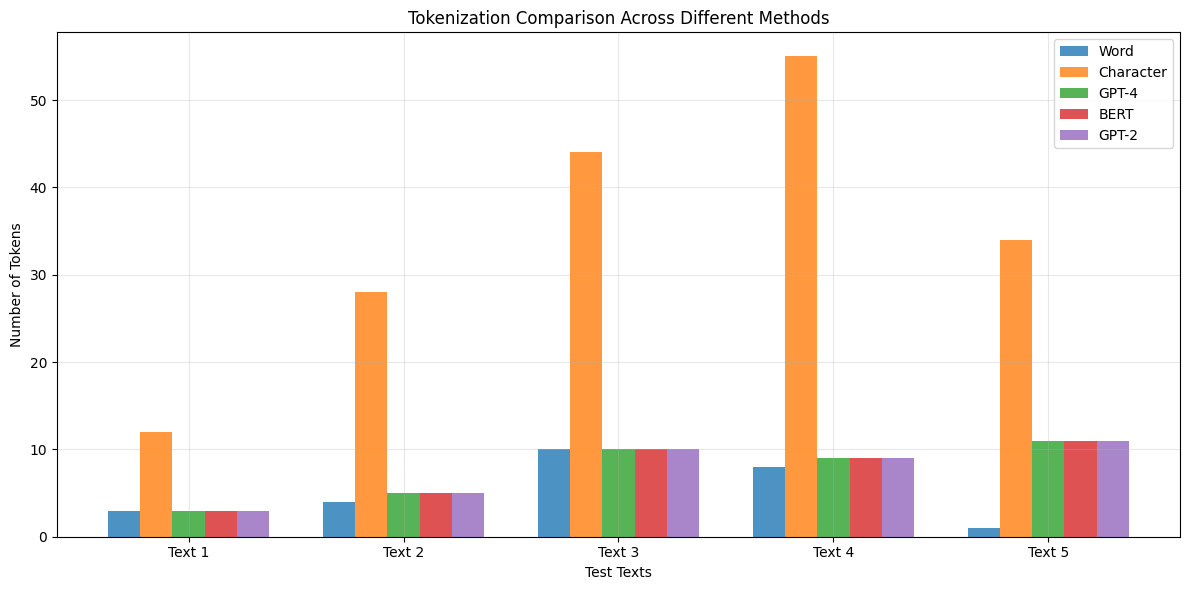

In [10]:
# Create visualization
methods = ['Word', 'Character', 'GPT-4', 'BERT', 'GPT-2']
text_labels = [f"Text {i+1}" for i in range(len(test_texts))]

word_counts = [r['word'] for r in results]
char_counts = [r['char'] for r in results]
gpt4_counts = [r['gpt4'] for r in results]
bert_counts = [r['bert'] for r in results]
gpt2_counts = [r['gpt2'] for r in results]

x = np.arange(len(text_labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 2*width, word_counts, width, label='Word', alpha=0.8)
ax.bar(x - width, char_counts, width, label='Character', alpha=0.8)
ax.bar(x, gpt4_counts, width, label='GPT-4', alpha=0.8)
ax.bar(x + width, bert_counts, width, label='BERT', alpha=0.8)
ax.bar(x + 2*width, gpt2_counts, width, label='GPT-2', alpha=0.8)

ax.set_xlabel('Test Texts')
ax.set_ylabel('Number of Tokens')
ax.set_title('Tokenization Comparison Across Different Methods')
ax.set_xticks(x)
ax.set_xticklabels(text_labels)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Special Tokens and Edge Cases

In [11]:
# Demonstrate special tokens
special_text = "Hello! How are you? I'm fine. 😊 Check out https://example.com"

print("Special tokens and edge cases:")
print(f"Text: {special_text}")
print()

# GPT-4 handling
gpt4_special = gpt4_tokenizer.encode(special_text)
gpt4_decoded_special = [gpt4_tokenizer.decode([token]) for token in gpt4_special]
print(f"GPT-4 tokens: {gpt4_decoded_special}")

# BERT handling
bert_special = bert_tokenizer.tokenize(special_text)
print(f"BERT tokens: {bert_special}")

# Show special tokens in BERT
bert_with_special = bert_tokenizer.encode(special_text, add_special_tokens=True)
bert_decoded_with_special = bert_tokenizer.convert_ids_to_tokens(bert_with_special)
print(f"BERT with special tokens: {bert_decoded_with_special}")

Special tokens and edge cases:
Text: Hello! How are you? I'm fine. 😊 Check out https://example.com

GPT-4 tokens: ['Hello', '!', ' How', ' are', ' you', '?', ' I', "'m", ' fine', '.', ' �', '�', ' Check', ' out', ' https', '://', 'example', '.com']
BERT tokens: ['hello', '!', 'how', 'are', 'you', '?', 'i', "'", 'm', 'fine', '.', '[UNK]', 'check', 'out', 'https', ':', '/', '/', 'example', '.', 'com']
BERT with special tokens: ['[CLS]', 'hello', '!', 'how', 'are', 'you', '?', 'i', "'", 'm', 'fine', '.', '[UNK]', 'check', 'out', 'https', ':', '/', '/', 'example', '.', 'com', '[SEP]']


## 8. Practical Implications for LLM Usage

In [12]:
# Token counting for cost estimation
def estimate_cost(text, model="gpt-4", input_cost_per_1k=0.03, output_cost_per_1k=0.06):
    """Estimate API cost based on token count"""
    if model == "gpt-4":
        tokenizer = tiktoken.encoding_for_model("gpt-4")
    else:
        tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
    
    token_count = len(tokenizer.encode(text))
    input_cost = (token_count / 1000) * input_cost_per_1k
    
    return {
        'tokens': token_count,
        'input_cost': input_cost,
        'estimated_output_tokens': token_count * 0.5,  # Rough estimate
        'estimated_total_cost': input_cost + ((token_count * 0.5) / 1000) * output_cost_per_1k
    }

# Example prompt
long_prompt = """
You are an AI assistant helping with data analysis. 
Please analyze the following dataset and provide insights:

Dataset: Sales data for Q1 2024
- January: $50,000 revenue, 200 customers
- February: $65,000 revenue, 250 customers  
- March: $80,000 revenue, 320 customers

Please provide:
1. Growth rate analysis
2. Customer acquisition trends
3. Revenue per customer metrics
4. Recommendations for Q2
"""

cost_analysis = estimate_cost(long_prompt)
print("Cost Analysis for Sample Prompt:")
print(f"Token count: {cost_analysis['tokens']}")
print(f"Input cost: ${cost_analysis['input_cost']:.4f}")
print(f"Estimated total cost: ${cost_analysis['estimated_total_cost']:.4f}")

Cost Analysis for Sample Prompt:
Token count: 100
Input cost: $0.0030
Estimated total cost: $0.0060


## 9. Best Practices and Optimization Tips

In [13]:
# Demonstrate token optimization techniques
verbose_prompt = """
I would like you to please help me with analyzing this data. 
Could you please take a look at the following information and 
provide me with some insights? I would really appreciate it if 
you could give me a detailed analysis.
"""

optimized_prompt = """
Analyze this data and provide insights:
"""

verbose_tokens = len(gpt4_tokenizer.encode(verbose_prompt))
optimized_tokens = len(gpt4_tokenizer.encode(optimized_prompt))

print("Prompt Optimization Example:")
print(f"Verbose prompt: {verbose_tokens} tokens")
print(f"Optimized prompt: {optimized_tokens} tokens")
print(f"Token reduction: {verbose_tokens - optimized_tokens} tokens ({((verbose_tokens - optimized_tokens) / verbose_tokens * 100):.1f}% reduction)")

print("\nBest Practices:")
print("1. Use concise language")
print("2. Avoid redundant phrases")
print("3. Use bullet points instead of long sentences")
print("4. Remove unnecessary politeness markers")
print("5. Use abbreviations where appropriate")
print("6. Structure data efficiently (JSON vs prose)")

Prompt Optimization Example:
Verbose prompt: 48 tokens
Optimized prompt: 9 tokens
Token reduction: 39 tokens (81.2% reduction)

Best Practices:
1. Use concise language
2. Avoid redundant phrases
3. Use bullet points instead of long sentences
4. Remove unnecessary politeness markers
5. Use abbreviations where appropriate
6. Structure data efficiently (JSON vs prose)


## 10. Interactive Token Counter

In [14]:
def interactive_token_counter(text):
    """Interactive function to analyze any text"""
    print(f"Text: {text}")
    print(f"Character count: {len(text)}")
    print()
    
    # Different tokenization methods
    word_tokens = word_tokenize(text)
    gpt4_tokens = gpt4_tokenizer.encode(text)
    bert_tokens = bert_tokenizer.tokenize(text)
    
    print(f"Word tokens: {len(word_tokens)}")
    print(f"GPT-4 tokens: {len(gpt4_tokens)}")
    print(f"BERT tokens: {len(bert_tokens)}")
    print()
    
    # Show actual tokens
    gpt4_decoded = [gpt4_tokenizer.decode([token]) for token in gpt4_tokens]
    print(f"GPT-4 tokenization: {gpt4_decoded}")
    print(f"BERT tokenization: {bert_tokens}")
    
    return {
        'word_count': len(word_tokens),
        'gpt4_count': len(gpt4_tokens),
        'bert_count': len(bert_tokens)
    }

# Test with different examples
test_cases = [
    "AI is amazing!",
    "The quick brown fox jumps over the lazy dog.",
    "Antidisestablishmentarianism",
    "🚀 Rocket to the moon! 🌙"
]

for test_text in test_cases:
    print("=" * 60)
    interactive_token_counter(test_text)
    print()

Text: AI is amazing!
Character count: 14

Word tokens: 4
GPT-4 tokens: 4
BERT tokens: 4

GPT-4 tokenization: ['AI', ' is', ' amazing', '!']
BERT tokenization: ['ai', 'is', 'amazing', '!']

Text: The quick brown fox jumps over the lazy dog.
Character count: 44

Word tokens: 10
GPT-4 tokens: 10
BERT tokens: 10

GPT-4 tokenization: ['The', ' quick', ' brown', ' fox', ' jumps', ' over', ' the', ' lazy', ' dog', '.']
BERT tokenization: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']

Text: Antidisestablishmentarianism
Character count: 28

Word tokens: 1
GPT-4 tokens: 6
BERT tokens: 8

GPT-4 tokenization: ['Ant', 'idis', 'establish', 'ment', 'arian', 'ism']
BERT tokenization: ['anti', '##dis', '##est', '##ab', '##lish', '##ment', '##arian', '##ism']

Text: 🚀 Rocket to the moon! 🌙
Character count: 23

Word tokens: 7
GPT-4 tokens: 11
BERT tokens: 7

GPT-4 tokenization: ['�', '�', '�', ' Rocket', ' to', ' the', ' moon', '!', ' �', '�', '�']
BERT tokenization: ['[UNK

## Summary and Key Takeaways

### What We Learned:

1. **Tokenization Methods**:
   - Word-level: Simple but large vocabulary
   - Character-level: Small vocabulary but long sequences
   - Subword (BPE): Balanced approach used by modern LLMs

2. **Modern Tokenizers**:
   - GPT models use tiktoken with BPE
   - BERT uses WordPiece tokenization
   - Each has different vocabulary and token counts

3. **Practical Implications**:
   - Token count affects API costs
   - Different models tokenize differently
   - Optimization can reduce costs significantly

4. **Best Practices**:
   - Monitor token usage for cost control
   - Optimize prompts for efficiency
   - Understand model-specific tokenization
   - Consider special tokens and edge cases

### Next Steps:
- Experiment with your own text
- Try different models and compare tokenization
- Implement token counting in your applications
- Optimize prompts for better efficiency